In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, MessagePassing

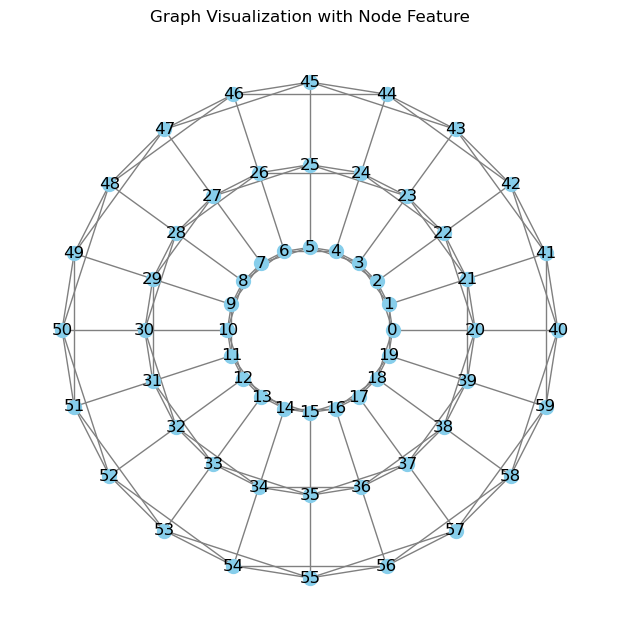

In [187]:
# Function to generate a concentric graph
def generate_concentric_graphs(layers, nodes_per_layer, k):
    G = nx.Graph()

    # Create nodes for each layer
    total_nodes = layers * nodes_per_layer
    for layer in range(layers):
        # Define the radius of the current layer
        radius = layer + 1
        # Calculate the angle between each point (in radians)
        angle_gap = 2 * np.pi / nodes_per_layer

        for i in range(nodes_per_layer):
            angle = i * angle_gap
            x, y = radius * np.cos(angle), radius * np.sin(angle)
            node_id = layer * nodes_per_layer + i
            G.add_node(node_id, pos=(x, y))

            # Connect each node to its k-hop neighbors in the same layer
            for hop in range(1, k + 1):
                neighbor_index = (i + hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)
                neighbor_index = (i - hop) % nodes_per_layer
                G.add_edge(node_id, layer * nodes_per_layer + neighbor_index)

    # Connect nodes between layers
    for layer in range(1, layers):
        for i in range(nodes_per_layer):
            this_layer_node = layer * nodes_per_layer + i
            inner_layer_node = (layer - 1) * nodes_per_layer + i
            G.add_edge(this_layer_node, inner_layer_node)

    # Get positions for visualization
    pos = nx.get_node_attributes(G, 'pos')
    return G, pos

# Paramaters for k_model graph
layers = 3
nodes_per_layer = 20
k_model = 2

# Generate the graph
G, pos = generate_concentric_graphs(layers, nodes_per_layer, k_model)

# Convert networkx graph to PyTorch Geometric Data
data = pyg_utils.from_networkx(G)

# Plot the graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=100, node_color="skyblue", edge_color="gray")
plt.title("Graph Visualization with Node Feature")
plt.show()

In [233]:
# Parameters for the time series
frequency = 1
time_steps = 200
influence_strength = 2
'''For each node at each time step, add all its neighbor's previous time step together to make a noise (Becomes mean of a gaussian distribution)'''
# Function to generate random time series (sine waves)
def generate_initial_time_series(num_nodes, frequency, time_steps, i):
    np.random.seed(i)
    initial_time_series = np.zeros((num_nodes, time_steps))

    for i in range(num_nodes):
        random_start = np.random.rand() * 2 * np.pi  # Generate a random starting point
        t = np.linspace(random_start, random_start + 32 * np.pi, time_steps)
        
        # Generate Gaussian noise
        #noise = np.random.normal(0, 0.1, time_steps)
        
        initial_time_series[i, :] = np.sin(frequency * t) #+ noise

    return initial_time_series

# Function to adjust the time series based on k-hop neighbors
def adjust_time_series_for_neighbors(G, time_series, influence_strength):
    adjusted_time_series = time_series.copy()
    for t in range(1, time_series.shape[1]):
        for node in G.nodes():
            neighbors = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
            neighbors.remove(node) 
            if neighbors:
                # Calculate the mean of the previous time step values of neighbors
                mean_neighbors = np.mean([time_series[neighbor, t-1] for neighbor in neighbors])
                # Generate Gaussian noise based on this mean
                noise = np.random.normal(mean_neighbors, 0.5)
                # Adjust current time step value by adding generated noise
                adjusted_time_series[node, t] += influence_strength * noise

    return adjusted_time_series

def normalize_time_series(time_series):
    num_nodes = time_series.shape[0] 
    normalized_time_series = np.zeros(time_series.shape)
    
    for i in range(num_nodes):
        # Calculate the min and max across all nodes and time steps
        min_val = np.min(time_series[i])
        max_val = np.max(time_series[i])
    
        # Normalize the time series to the range [-1, 1]
        normalized_time_series[i] = 2 * ((time_series[i] - min_val) / (max_val - min_val)) - 1
    
    return normalized_time_series

# Generate initial time series
initial_time_series = generate_initial_time_series(G.number_of_nodes(), frequency, time_steps, 0)

# Generate k_data graph and adjust the time series based on the k-hop neighbors (k_data)
k_data = 2
G_data, pos_data = generate_concentric_graphs(layers, nodes_per_layer, k_data)

adjusted_time_series = adjust_time_series_for_neighbors(G_data, initial_time_series, influence_strength)
normalized_adjusted_time_series = normalize_time_series(adjusted_time_series)

torch.Size([159, 60, 1]) torch.Size([159, 60, 1])


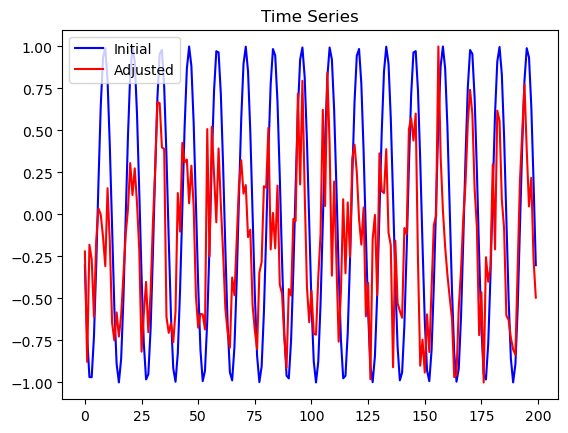

In [235]:
# Define the number of previous time step used to predict next time step
previous_step = 1

# Add time series to Data
num_training = int(time_steps*0.8)
data.y = torch.tensor(normalized_adjusted_time_series[:, 0:num_training], dtype=torch.float)
data.input = []
data.output = []
for i in range(num_training - previous_step):
    data.input.append(data.y[:, i:i+previous_step])
    data.output.append(data.y[:, i+previous_step:i+previous_step+1])
data.input = torch.stack(data.input)
data.output = torch.stack(data.output)
print(data.input.shape, data.output.shape)

plt.plot(initial_time_series[0], 'b', label = 'Initial')
plt.plot(normalized_adjusted_time_series[0], 'r', label = 'Adjusted')
plt.title("Time Series")
plt.legend()

In [237]:
class GNNModel(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channel, k_data):
        super(GNNModel, self).__init__(aggr='add')
        
        # Initialize the 2 GCNConv layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Linear layer for forecasting the next time step value
        self.linear = nn.Linear(hidden_channels, out_channel)
        
    def forward(self, y, edge_index):  
        # Pass through the 2 GCNConv layers with a non-linear layer after each linear layer
        # Used tanh as its range is from -1 to 1 which is the same as range of sin function
        x = torch.tanh(self.conv1(y, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        
        # Forecast the next time step value and normalize output to [-1, 1]
        x = torch.tanh(self.linear(x))

        return x
    
# Parameters for the GNN Model
hidden_channels = 64
out_channel = 1

# Generate the models and predictions
model = GNNModel(previous_step, hidden_channels, out_channel, k_data)

In [239]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 100

# Training loop with teacher forcing
model.train()
    
for epoch in range(num_epochs): 
    node_loss = np.zeros(data.num_nodes)
    
    optimizer.zero_grad()

    # Forward pass
    output = model(data.input, data.edge_index)

    # Calculate loss
    target = data.output
    loss = criterion(output, target)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
        
    print(f'Epoch: {epoch + 1}, Average Loss: {loss.item()}')

Epoch: 1, Average Loss: 0.1557459980249405
Epoch: 2, Average Loss: 0.1525212526321411
Epoch: 3, Average Loss: 0.14969773590564728
Epoch: 4, Average Loss: 0.14728854596614838
Epoch: 5, Average Loss: 0.14528436958789825
Epoch: 6, Average Loss: 0.14362944662570953
Epoch: 7, Average Loss: 0.14222171902656555
Epoch: 8, Average Loss: 0.14097332954406738
Epoch: 9, Average Loss: 0.13985230028629303
Epoch: 10, Average Loss: 0.13886933028697968
Epoch: 11, Average Loss: 0.13805212080478668
Epoch: 12, Average Loss: 0.13742868602275848
Epoch: 13, Average Loss: 0.13701669871807098
Epoch: 14, Average Loss: 0.13681460916996002
Epoch: 15, Average Loss: 0.13679420948028564
Epoch: 16, Average Loss: 0.13690027594566345
Epoch: 17, Average Loss: 0.13706600666046143
Epoch: 18, Average Loss: 0.1372368335723877
Epoch: 19, Average Loss: 0.13738267123699188
Epoch: 20, Average Loss: 0.1374947726726532
Epoch: 21, Average Loss: 0.13757635653018951
Epoch: 22, Average Loss: 0.13763310015201569
Epoch: 23, Average Loss

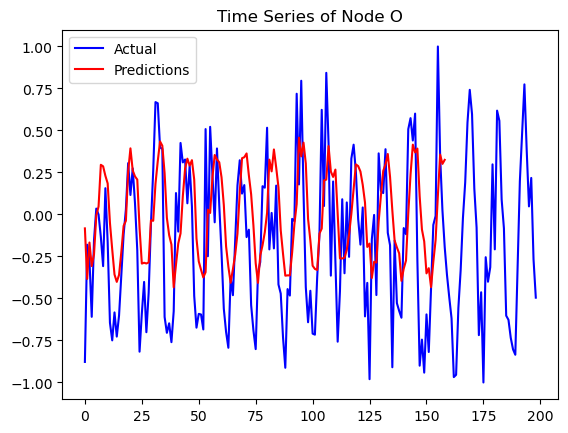

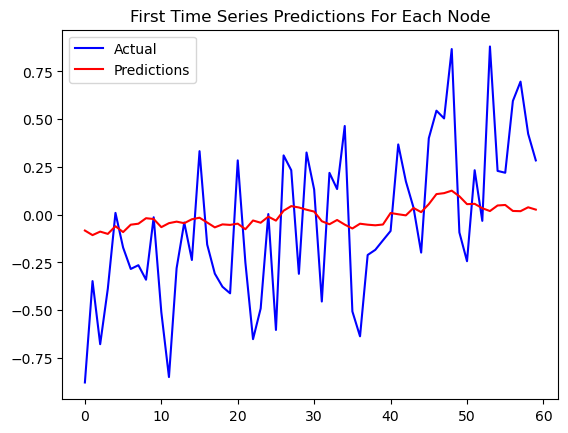

In [241]:
def predictions(model, data, num_time_steps, previous_step):
    # Initialize the predictions tensor
    num_nodes = data.num_nodes
    predictions = torch.empty((0, num_nodes, 1))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for t in range(num_time_steps):
            # Predict the next time step value
            predicted_next_values = model(data.input[t:t+previous_step:, :, :], data.edge_index)
            predictions = torch.cat([predictions, predicted_next_values], dim=0)
            # print(predictions)
    return predictions

# Perform the prediction (Num_training - previous_step as there no previous data in training set)
predictions_values = predictions(model, data, num_training-previous_step, previous_step)
# print(predictions_values.shape)
# print(data.input.shape)
# print(data.output.shape)

# Plot Time Series of Node O
node = 0
plt.plot(normalized_adjusted_time_series[node, previous_step:], 'b', label = 'Actual')
plt.plot(predictions_values[:, node, 0], 'r', label = 'Predictions')
plt.title("Time Series of Node O")
plt.legend()

# Plot First Time Series Predictions For Each Node
plt.figure()
time = 0
plt.plot(normalized_adjusted_time_series[:, previous_step + time], 'b', label = 'Actual')
plt.plot(predictions_values[time, :, 0], 'r', label = 'Predictions')
plt.title("First Time Series Predictions For Each Node")
plt.legend()

In [243]:
def accuracy(k_model, k_data):

    # Paramaters for k_model graph
    layers = 3
    nodes_per_layer = 20
    # Generate the graph
    G, pos = generate_concentric_graphs(layers, nodes_per_layer, k_model)
    # Convert networkx graph to PyTorch Geometric Data
    data = pyg_utils.from_networkx(G)
    
    # Parameters for the time series
    frequency = 1
    time_steps = 200
    influence_strength = 0.5
    # Generate initial time series
    initial_time_series = generate_initial_time_series(G.number_of_nodes(), frequency, time_steps, 0)
    # Generate k_data graph and adjust the time series based on the k-hop neighbors (k_data)
    G_data, pos_data = generate_concentric_graphs(layers, nodes_per_layer, k_data)
    adjusted_time_series = adjust_time_series_for_neighbors(G_data, initial_time_series, influence_strength)
    normalized_adjusted_time_series = normalize_time_series(adjusted_time_series)
    
    # Define the number of previous time step used to predict next time step
    previous_step = 1
    # Add time series to Data
    num_training = int(time_steps*0.8)
    data.y = torch.tensor(normalized_adjusted_time_series[:, 0:num_training], dtype=torch.float)
    data.input = []
    data.output = []
    for i in range(num_training - previous_step):
        data.input.append(data.y[:, i:i+previous_step])
        data.output.append(data.y[:, i+previous_step:i+previous_step+1])
    data.input = torch.stack(data.input)
    data.output = torch.stack(data.output)
    
    # Parameters for the GNN Model
    hidden_channels = 64
    out_channel = 1
    # Generate the models and predictions
    model = GNNModel(previous_step, hidden_channels, out_channel, k_data)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Define the number of epochs
    num_epochs = 100
    # Training loop with teacher forcing
    model.train()
    for epoch in range(num_epochs): 
        node_loss = np.zeros(data.num_nodes)
        optimizer.zero_grad()
        # Forward pass
        output = model(data.input, data.edge_index)
        # Calculate loss
        target = data.output
        loss = criterion(output, target)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    '''Try one step ahead for validation. Not roll out'''
    # Add validation time series to Data
    data.validation = torch.tensor(normalized_adjusted_time_series[:, num_training-previous_step:time_steps], dtype=torch.float)
    num_validation = time_steps - num_training
    data.input = []
    data.output = []
    for i in range(num_validation):
        data.input.append(data.validation[:, i:i+previous_step])
        data.output.append(data.validation[:, i+previous_step:i+previous_step+1])
    data.input = torch.stack(data.input)
    data.output = torch.stack(data.output)
    
    # Validation Loss
    predictions_values = predictions(model, data, num_validation, previous_step) 
    target = data.output
    loss = criterion(predictions_values, target)
    
    # # Plot Time Series of Node O - k_model, k_data
    # plt.figure()
    # node = 0
    # plt.plot(normalized_adjusted_time_series[node, num_training:], 'b', label = 'Actual')
    # plt.plot(predictions_values[:, node, 0], 'r', label = 'Predictions')
    # plt.title(f"Time Series of Node O - k_model: {k_model}, k_data: {k_data}")
    # plt.legend()
        
    return loss.item()

# Result of Different k Combinations
accuracy_table = pd.DataFrame(index=range(1, 8), columns=range(1, 8))
for i in range(1, 8):
    for j in range(1, 8):
        accuracy_table.loc[i][j] = accuracy(i, j)

# Print Visualization: rows represents k_model, columns represent k_data, values are errors
print("Errors: k model vs k data")
print(accuracy_table)

Errors: k model vs k data
          1         2         3         4         5         6         7
1  0.167526  0.174191  0.173382  0.172754  0.173806  0.176205   0.17739
2   0.18752  0.193767  0.190552  0.190169  0.191624  0.195199  0.196242
3  0.203605  0.208988  0.204092  0.202837  0.204691   0.20879  0.209289
4  0.209684  0.215235  0.211004  0.209645  0.210834  0.214489  0.215231
5  0.213505  0.218786  0.214461  0.212366  0.213847  0.216579  0.217168
6  0.222423  0.227524  0.222418  0.220339  0.221589  0.224714  0.224847
7  0.227069  0.232394  0.227015  0.225005  0.225633  0.228413   0.22848
